<a href="https://colab.research.google.com/github/nw93929/DS4002-CS3/blob/main/CODE/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone github to access data
! git clone https://github.com/nw93929/DS4002-CS3 # so we can access data loaded from shared github

Cloning into 'DS4002-CS3'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 5.51 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# disable deprecation warning to read output easier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import tests and VAR model from statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# read in data
data = pd.read_csv("/content/Project2_DS4002/DATA/Final Dataset/Hurricane_Dataset.csv", index_col='Year')

# get rid of unneeded columns and take look at data
data = data[data.columns[2:]]
data.head()

,Total_Hurricane_Days,CO2_emissions,Population,CSIRO_Adjusted_SeaLevel_Inch,Surface_Temperature_Change,SurfaceSeaTemp_Annual_Anomaly
Year,,,,,,
1971,67.25,1.550279e+10,3769847834,4.881890,-0.093,-0.519
1972,40.00,1.622344e+10,3844917687,5.240157,-0.199,-0.193
1973,38.50,1.708350e+10,3920805030,5.003937,0.269,-0.151
1974,37.00,1.700938e+10,3996416108,5.472441,-0.181,-0.427
1975,47.25,1.704998e+10,4070735264,5.409449,0.088,-0.445


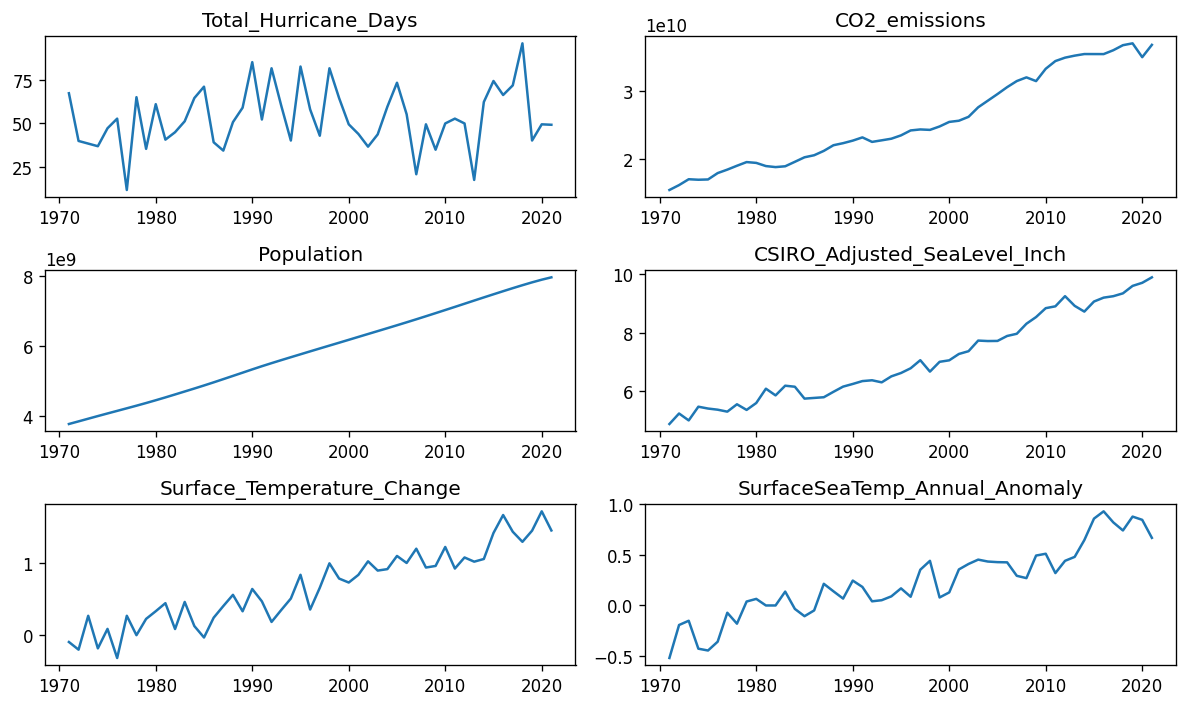

In [ ]:
# set up plot structure and plot individual time series
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    temp = data[data.columns[i]]
    ax.plot(temp)
    ax.set_title(data.columns[i])

plt.tight_layout();

We can see many of the series have similar patterns and trends over time, since they seem correlated, we can check for causality among these series using the Granger's Causality test.

In [ ]:
# perform granger's causality test for every combination of relationships
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
# write a function to perform test

# use the function to perform test
grangers_causation_matrix(data, variables = data.columns)

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero. It essentially tests to see if the past values of the X time series cause the values of the Y time series. If we are able to reject the null hypothesis, it means the coefficients are NOT zero, and that there is indeed a relationship. In our scenario, we see that all the cross relations (the diagonal is its relation with itself so it will always be 1), are significant so we can proceed with our analysis using all variables.

In [ ]:
# cointegration test to test statistically significant relationships
def cointegration_test(df, alpha=0.05):
# write a function to perform test

# use function to perform test
cointegration_test(data)

The Cointegration test sees if a linear combination of some series have an order of integration less than that of the individual series. Essentially it sees if a combination of series converges to stationary faster than the individual series, indicating a statistically significant relationship. It is the basic assumption on which Vector Autoregression(VAR) models are based on. In our scenario we see that all the variables are significant, we can proceed with our analysis with our VAR model assumption met.

In [ ]:
# split into training and testing datasets
nobs = 4 # we are gonna predict 4 time periods ahead (4 months)
data_train, data_test = data[0:-nobs], data[-nobs:]
print(data_train.shape)
print(data_test.shape)

(47, 6)
(4, 6)


In [ ]:
def adf_test(series, signif=0.05, name='', verbose=False):
# write a function to perform test

# ADF Test on each variable
for name, column in data_train.items():
    adf_test(column, name=column.name)
    print('\n')

In [ ]:
# difference series and re-run ADF test if needed to achieve stationarity

All series should now be stationary, meeting our VAR model assumptions! Now we can start fitting models and comparing them using the AIC scores.

In [ ]:
# compare models of increasing lag and compute AIC scores

In [ ]:
# fit the optimal order VAR model with lowest AIC value (we want to avoid fitting higher order models if possible, if too high order, consider a lower order with a slightly worse AIC value)

We have our model now, now we must see how well it actually describes the patterns in the data by looking at the residuals. If there is still leftover correlation in the residuals, it means the model does not explain all the patterns in the time series.

In [ ]:
# calculate the durbin watson statistic to check residuals

Ideally, we want the statistic to be around 2 as it being closer to 0 or 4 indicates signs of leftover correlation in the residuals. We notice that this is adhered to for the most part except by the CO2_emissions. For the most part we can say the patterns in the data are being described well by the model, so we can continue to move forward and keep the outlier in mind.

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting

# Forecast

In [ ]:
# revert forecasts back to original scale before we differenced to interpret results easier
def invert_transformation(df_train, df_forecast):
# write function to revert forecasts

df_results = invert_transformation(data_traind1, df_forecast)
# take a look at reverted data to ensure it looks right
df_results.loc[:,['Total_Hurricane_Days_forecast','CO2_emissions_forecast','Population_forecast','CSIRO_Adjusted_SeaLevel_Inch_forecast','Surface_Temperature_Change_forecast','SurfaceSeaTemp_Annual_Anomaly_forecast']]

In [ ]:
# plot forecast vs actual

Reflect on model predicting performance. Consider if the pattern is roughly captured and the actual value accuracy.

In [ ]:
# get some accuracy metrics on the forecast
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
# write function to calculate RMSE

Forecast Accuracy of: Total_Hurricane_Days
rmse   :  62.1703


Reflect on the RMSE, what does this tell you? Perhaps the relationship is not straight forward enough between these time series to accurately predict hurricane days if it is too high.